In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras-tuner
!pip install tensorflow_addons
!pip install pycm
from keras.utils import np_utils
from kerastuner.tuners import RandomSearch
import kerastuner as kt
from tensorflow.keras import layers
from keras_tuner import RandomSearch
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,EarlyStopping
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D,BatchNormalization
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa
from sklearn.utils import class_weight
import tensorflow as tf
from pycm import ConfusionMatrix
from imblearn.over_sampling import SMOTE, ADASYN

     |████████████████████████████████| 97 kB 2.6 MB/s 
     |████████████████████████████████| 1.1 MB 2.8 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  after removing the cwd from sys.path.


In [3]:
df=pd.read_csv('/content/drive/MyDrive/Melanoma Project/final.csv')
df.head()

,Family_History,Patient_History,Patient_Sex,Patient_Age,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,Melanoma
0,1,1,1,1.374412,0.000000,0.000000,0.000000,0.0,0.895281,0.170424,0.334496,0.535144,0.000000,0.838951,1.313835,0.0,0.799786,0.848957,0.766729,0.072602,0.000000,0.744514,0.271474,0.427653,0.0,0.225046,0.898221,0.105062,0.486301,0.332734,0.989699,0.000000,1.105003,0.000000,0.000000,0.243165,0
1,1,0,1,0.785378,0.428445,0.808372,0.410599,0.0,0.000000,0.782431,0.000000,0.000000,0.201100,0.000000,1.692971,0.0,0.000000,0.085503,1.626967,0.000000,0.524208,1.524392,0.000000,0.000000,0.0,0.000000,0.895318,0.389831,0.000000,1.209965,1.254844,0.467543,0.012432,0.611834,0.765858,0.598891,1
2,1,0,1,0.785378,0.671592,1.086340,0.713988,0.0,0.000000,0.988801,0.000000,0.000000,0.371980,0.000000,1.817110,0.0,0.000000,0.000000,1.996230,0.000000,0.578080,1.840052,0.000000,0.000000,0.0,0.000000,1.517236,0.362477,0.000000,1.636171,1.432802,0.800722,0.000000,1.061281,0.950372,0.683324,1
3,1,1,0,0.883551,0.615322,0.877099,0.626662,0.0,0.000000,1.120432,0.000000,0.000000,0.544277,0.000000,1.498737,0.0,0.000000,0.000000,1.821136,0.000000,0.370582,1.988797,0.000000,0.000000,0.0,0.000000,1.588848,0.510777,0.000000,1.399091,1.189754,0.802155,0.000000,1.460947,1.134553,0.553451,1
4,1,1,1,0.981723,0.212209,0.627659,0.242865,0.0,0.000000,0.614922,0.000000,0.014604,0.175750,0.000000,1.565679,0.0,0.000000,0.316299,1.365290,0.000000,0.292966,1.309489,0.000000,0.001812,0.0,0.000000,0.751302,0.281071,0.000000,0.987256,1.237673,0.329191,0.143877,0.644764,0.543582,0.544338,1


In [4]:
df['Melanoma'].value_counts()

1    993
0    264
Name: Melanoma, dtype: int64

# Train-test split

In [62]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

X_train, y_train = SMOTE().fit_resample(X_train, y_train)

y_train=np.ravel(y_train)
y_test=np.ravel(y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# ANN

In [73]:
def plot(folderpath,modelname):
  history  = pd.read_csv(folderpath+modelname +'.csv')
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [82]:
model = Sequential()
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# create the model

#compile the model
oFocalLoss = 'binary_crossentropy'#tfa.losses.SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.AUTO)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=oFocalLoss,metrics = ['accuracy'])

In [83]:
folderpath = '/content/drive/MyDrive/Melanoma Project/Models/'
modelname='ANN'

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(folderpath + modelname + ".hdf5",  monitor='val_accuracy', verbose=0, save_weights_only=False,save_best_only=True, mode='max')
csv_logger = CSVLogger(folderpath+modelname +'.csv')

#create callbacks for monitoring training
tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)

early_stoping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
#create callback for reducing learning rate
reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, mode = 'min',min_lr=0.0005,verbose =1)

callbacks=[cp_callback,tb_callback,csv_logger,reduce_lr,early_stoping]

In [84]:
history=model.fit(X_train, y_train,batch_size=32, epochs=200, callbacks=callbacks,validation_split=0.2,verbose=1,shuffle=True)

Epoch 1/200
48/48 [==============================] - 3s 23ms/step - loss: 0.7519 - accuracy: 0.5358 - val_loss: 0.7069 - val_accuracy: 0.4683
Epoch 2/200
48/48 [==============================] - 1s 11ms/step - loss: 0.7325 - accuracy: 0.5544 - val_loss: 0.7206 - val_accuracy: 0.4683
Epoch 3/200
48/48 [==============================] - 0s 10ms/step - loss: 0.7250 - accuracy: 0.5477 - val_loss: 0.7253 - val_accuracy: 0.4683
Epoch 4/200
48/48 [==============================] - 0s 10ms/step - loss: 0.6879 - accuracy: 0.5935 - val_loss: 0.7264 - val_accuracy: 0.4683
Epoch 5/200
48/48 [==============================] - 1s 11ms/step - loss: 0.6838 - accuracy: 0.5836 - val_loss: 0.7234 - val_accuracy: 0.4683
Epoch 6/200
48/48 [==============================] - 1s 11ms/step - loss: 0.6725 - accuracy: 0.6061 - val_loss: 0.7172 - val_accuracy: 0.4683
Epoch 7/200
48/48 [==============================] - 1s 12ms/step - loss: 0.6616 - accuracy: 0.6147 - val_loss: 0.7009 - val_accuracy: 0.4735
Epoch 

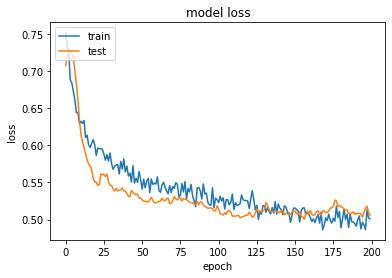

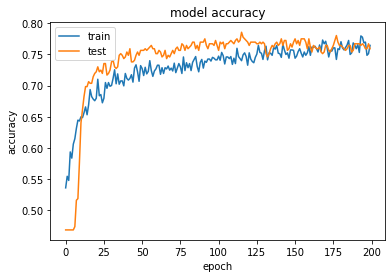

In [85]:
plot(folderpath,modelname)

In [86]:
y_pred = model.predict(X_test)
y_pred = [round(i[0]) for i in y_pred]

In [92]:
def cal_accuracy(y_test, y_pred): 
    print ("Accuracy : ", accuracy_score(y_test,y_pred)*100) 
    print("Report : ", classification_report(y_test, y_pred)) 
    print(ConfusionMatrix(actual_vector=list(y_test),predict_vector=list(y_pred)))

cal_accuracy(y_test, y_pred)

Accuracy :  77.0
Report :                precision    recall  f1-score   support

           0       0.75      0.82      0.78        50
           1       0.80      0.72      0.76        50

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100

Predict  0        1        
Actual
0        41       9        

1        14       36       





Overall Statistics : 

95% CI                                                            (0.68752,0.85248)
ACC Macro                                                         0.77
ARI                                                               0.28444
AUNP                                                              0.77
AUNU                                                              0.77
Bangdiwala B                                                      0.5954
Bennett S                                                         0.54
CBA        